# Regresión lineal básica — Housing

Pasos:
1) Carga y exploración de datos  
2) Preprocesamiento (nulos + one-hot)  
3) División train/test  
4) Regresión lineal (scikit-learn)  
5) Evaluación (MSE, MAE, R²)  
6) Visualizaciones finales


Importar y configuración básica

In [1]:
# Librerías base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# scikit-learn: preprocesado, modelos, métricas y pipelines
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc
)



2. Carga y verificacion rápida dataset

In [3]:
df = pd.read_csv("dataset.csv")

print(df.shape)
print("\n columnas: ", df.columns.tolist())
print("\n Tipos de datos por columna", df.dtypes)

(891, 12)

 columnas:  ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

 Tipos de datos por columna PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
print("Valores nulos por columna \n:", df.isna().sum())

Valores nulos por columna 
: PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


3. Revision balance de clases

Distribución de la variable objetivo
Survived
0    549
1    342
Name: count, dtype: int64


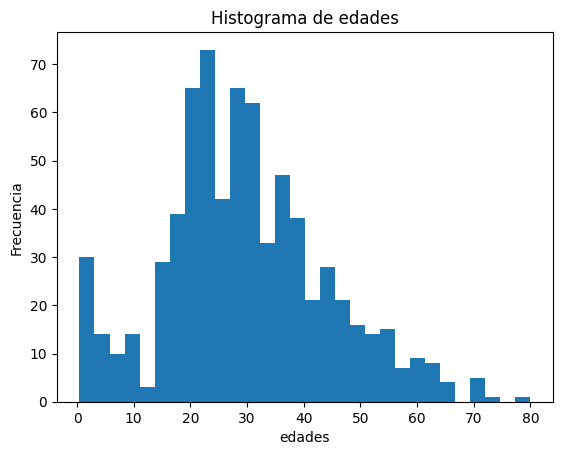

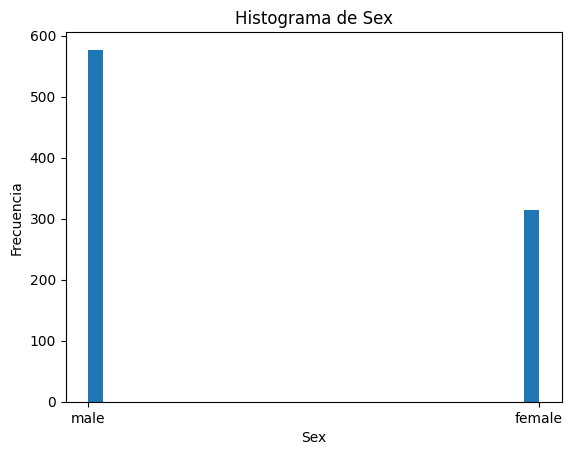

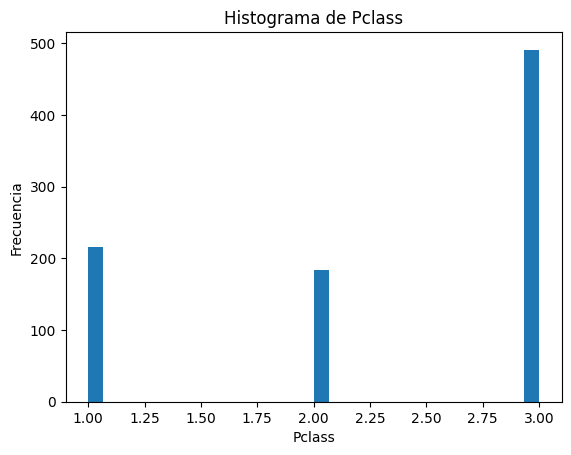

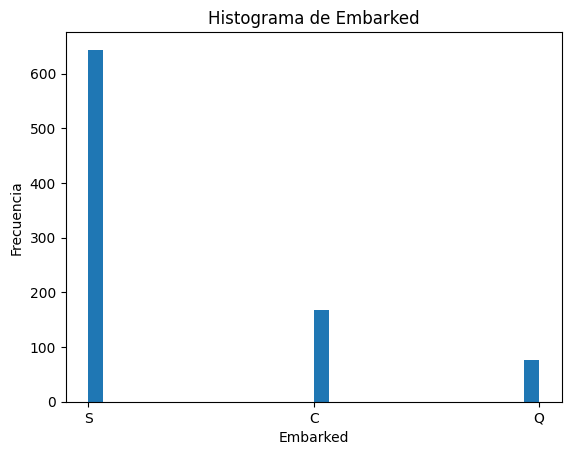

In [11]:
print("Distribución de la variable objetivo")
print(df['Survived'].value_counts(dropna = True))

plt.figure()
plt.hist(df["Age"].dropna(), bins = 30)
plt.title("Histograma de edades")
plt.xlabel("edades")
plt.ylabel("Frecuencia")


for cat_col in ["Sex", "Pclass", "Embarked"]:
    plt.figure()
    plt.hist(df[cat_col].dropna(), bins = 30)
    plt.title(f"Histograma de {cat_col}")
    plt.xlabel(cat_col)
    plt.ylabel("Frecuencia")



4. Separación de features

In [14]:
feature_cols = [ c for c in df.columns if c != "Survived"]

X_raw = df[feature_cols].copy()
y_raw = df["Survived"]

# Detectar columnas numéricas y categóricas automáticamente
num_cols = X_raw.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_raw.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)

Numéricas: ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categóricas: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


Preprocesamiento -> one-hot + imputacion + escalado

In [16]:
# 2) Preprocesamiento
# Numéricas: imputar mediana + escalar (StandardScaler)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categóricas: imputar moda + One-Hot (ignorar categorías nuevas en test)
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combinar en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

print("Preprocesador listo.")


Preprocesador listo.


6. Train-test split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    x_raw, y_raw, test_size = 0.2
)

print("Shapes -> X_train:", X_train.shape, "| X_test:", X_test.shape)
print("Proporción de clases (train):")
print(y_train.value_counts(normalize=True).round(3))



Shapes -> X_train: (712, 11) | X_test: (179, 11)
Proporción de clases (train):
Survived
0    0.624
1    0.376
Name: proportion, dtype: float64


7. Definir los 5 modelos

In [19]:
# 4) Modelos con pipeline: preprocessor + classifier
models = {
    "LogisticRegression": Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=1000))
    ]),
    "KNN": Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", KNeighborsClassifier(n_neighbors=5))
    ]),
    "SVC": Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", SVC(probability=True))  # probability para ROC/AUC
    ]),
    "DecisionTree": Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", DecisionTreeClassifier(random_state=42))
    ]),
    "RandomForest": Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(n_estimators=200, random_state=42))
    ]),
}

list(models.keys())


['LogisticRegression', 'KNN', 'SVC', 'DecisionTree', 'RandomForest']

8. Entrenamiento de los 5 modelos

In [20]:
# 5) Entrenamiento
fitted = {}
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    fitted[name] = pipe
    print(f"{name}: entrenado.")


LogisticRegression: entrenado.
KNN: entrenado.
SVC: entrenado.
DecisionTree: entrenado.
RandomForest: entrenado.


In [21]:
def evaluate_model(name, clf, X_test, y_test):
    """
    Muestra:
    - Accuracy
    - Matriz de confusión (impresa y dibujada)
    - Classification report (precision, recall, f1) con zero_division=0
    - Curva ROC + AUC si el modelo expone scores
    """
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    print("Matriz de confusión:\n", cm)
    
    # Dibujo matriz de confusión
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Matriz de confusión — {name}")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Pred 0","Pred 1"])
    plt.yticks(tick_marks, ["Real 0","Real 1"])
    # anotar valores
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.xlabel("Predicción"); plt.ylabel("Real")
    plt.tight_layout()
    plt.show()
    
    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # ROC/AUC
    scores = None
    try:
        scores = clf.predict_proba(X_test)[:, 1]
    except Exception:
        try:
            scores = clf.decision_function(X_test)
        except Exception:
            pass
    
    if scores is not None:
        fpr, tpr, _ = roc_curve(y_test, scores)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.title(f"ROC — {name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.show()
    else:
        print("(No se pudo calcular ROC/AUC para este modelo)")



=== LogisticRegression ===
Accuracy: 0.8324
Matriz de confusión:
 [[91 14]
 [16 58]]


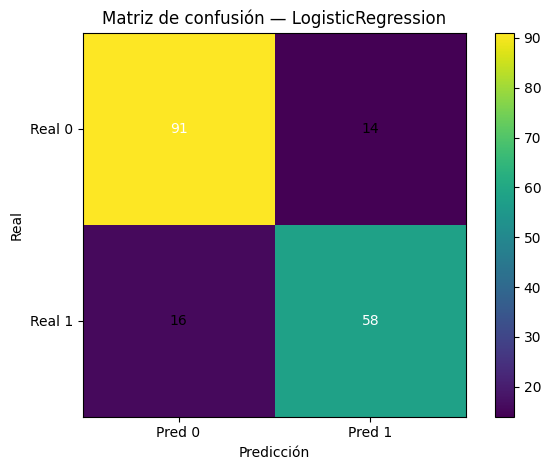


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       105
           1       0.81      0.78      0.79        74

    accuracy                           0.83       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.83      0.83      0.83       179



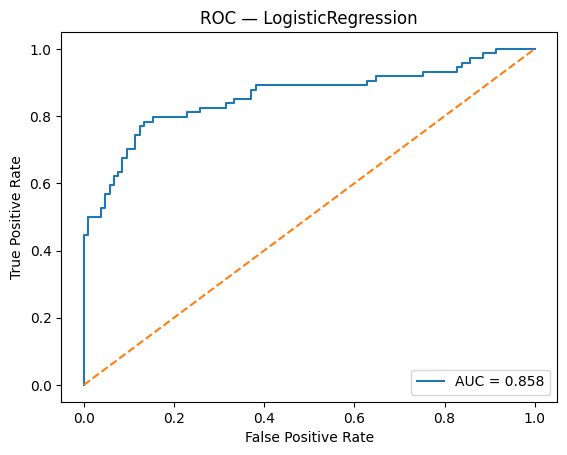


=== KNN ===
Accuracy: 0.8436
Matriz de confusión:
 [[95 10]
 [18 56]]


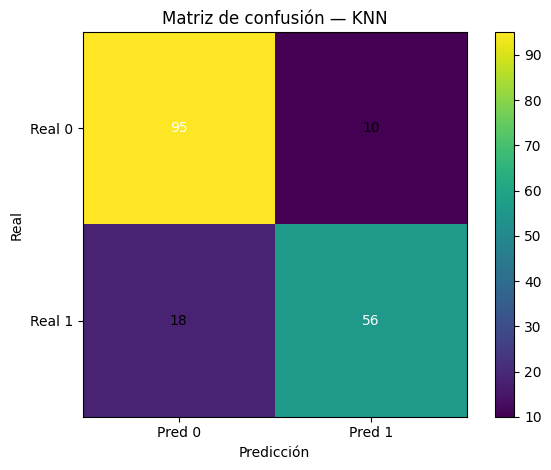


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       105
           1       0.85      0.76      0.80        74

    accuracy                           0.84       179
   macro avg       0.84      0.83      0.84       179
weighted avg       0.84      0.84      0.84       179



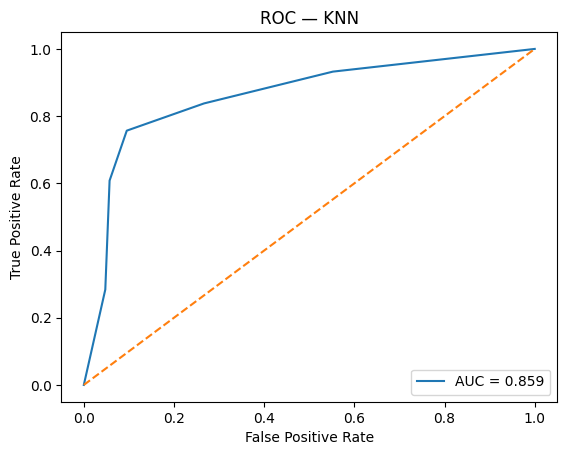


=== SVC ===
Accuracy: 0.8156
Matriz de confusión:
 [[92 13]
 [20 54]]


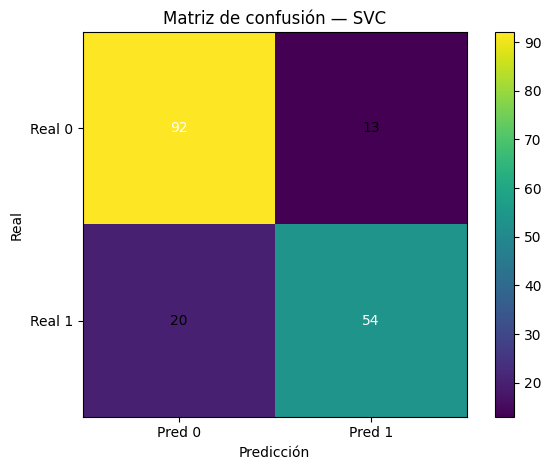


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       105
           1       0.81      0.73      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179



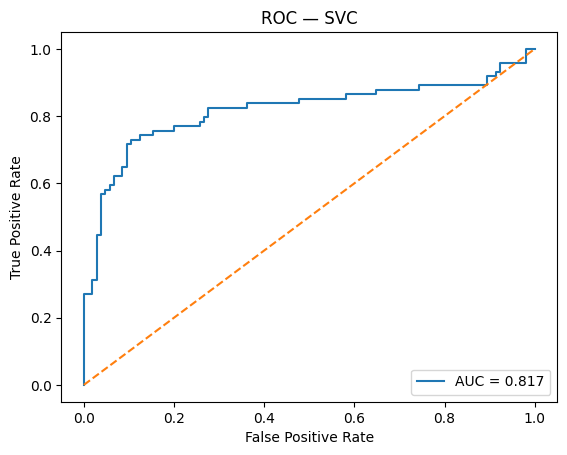


=== DecisionTree ===
Accuracy: 0.8547
Matriz de confusión:
 [[95 10]
 [16 58]]


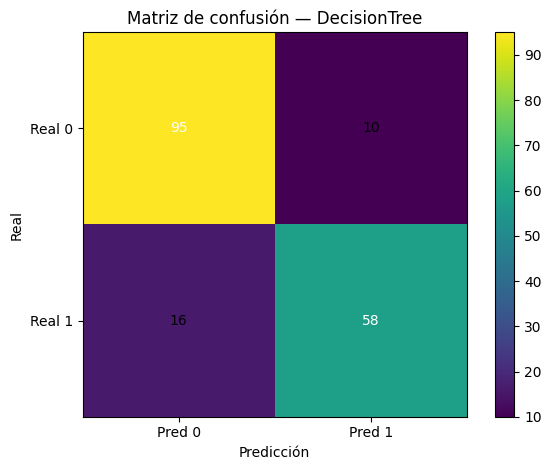


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       105
           1       0.85      0.78      0.82        74

    accuracy                           0.85       179
   macro avg       0.85      0.84      0.85       179
weighted avg       0.85      0.85      0.85       179



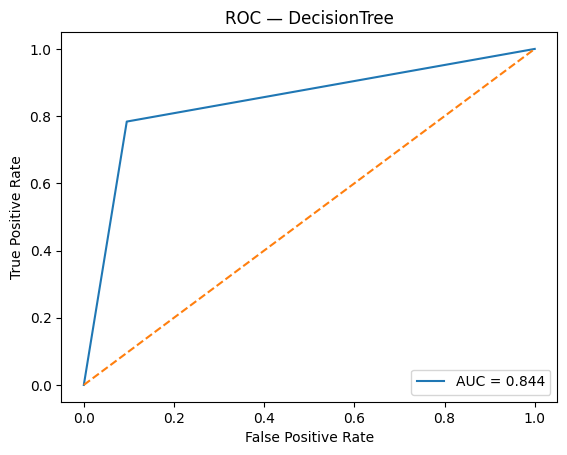


=== RandomForest ===
Accuracy: 0.8268
Matriz de confusión:
 [[94 11]
 [20 54]]


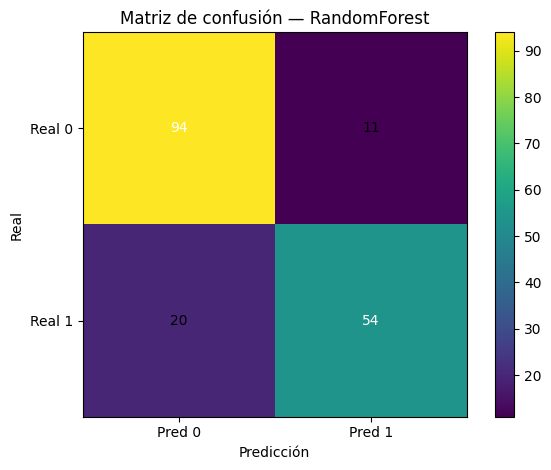


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       105
           1       0.83      0.73      0.78        74

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.82       179



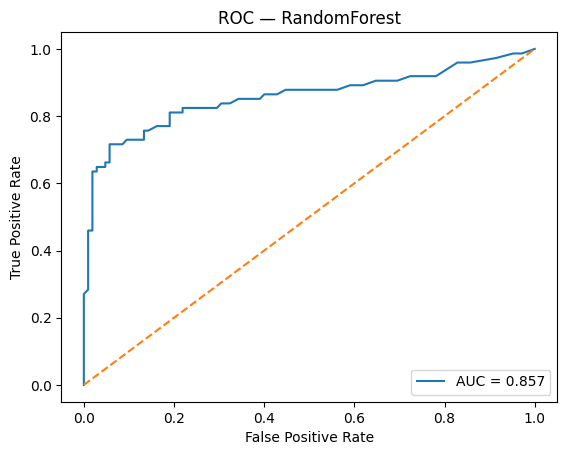


Accuracy de todos los modelos: {'LogisticRegression': 0.8324022346368715, 'KNN': 0.8435754189944135, 'SVC': 0.8156424581005587, 'DecisionTree': 0.8547486033519553, 'RandomForest': 0.8268156424581006}
Mejor accuracy: DecisionTree -> 0.8547


In [22]:
results = {}
for name, clf in fitted.items():
    print("="*60)
    evaluate_model(name, clf, X_test, y_test)
    results[name] = accuracy_score(y_test, clf.predict(X_test))

print("\nAccuracy de todos los modelos:", results)
best = max(results, key=results.get)
print(f"Mejor accuracy: {best} -> {results[best]:.4f}")
